<a href="https://colab.research.google.com/github/OscarOvanger/GeoDecepticon/blob/main/training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is where the training goes down

 We start of by installing the requirements

In [2]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

In [3]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

Cloning into 'GeoDecepticon'...
remote: Enumerating objects: 19671, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 19671 (delta 91), reused 73 (delta 70), pack-reused 19570 (from 2)
Receiving objects: 100% (19671/19671), 83.60 MiB | 16.30 MiB/s, done.
Resolving deltas: 100% (243/243), done.


In [4]:
import os
os.chdir('/content/GeoDecepticon')

In [5]:
from dataloader import BinaryImageDataset, preprocess_image
from transformer import VisionTransformer
from PointSSIM_Loss import PointSSIMLoss
import torch
import torch.optim as optim
import torch.nn as nn
import wandb
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sample import reconstruct_image_from_patches
import matplotlib.colors as mcolors
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import colors
import os
from torch.optim.lr_scheduler import StepLR

training data shape:  (6000, 64, 64)
test data shape:  (3423, 64, 64)


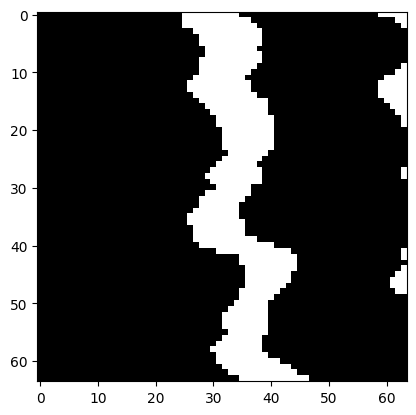

In [6]:
data_1 = np.load("data_array_1.npz")
data_2 = np.load("data_array_2.npz")
data_3 = np.load("data_array_3.npz")

data_array_1 = data_1['data_array']
data_array_2 = data_2['data_array']
data_array_3 = data_3['data_array']

training_data = np.concatenate((data_array_1, data_array_2), axis=0)
test_data = data_array_3
print("training data shape: ", training_data.shape)
print("test data shape: ", test_data.shape)

plt.imshow(training_data[0],cmap="gray")
plt.show()

In [7]:
# Create the embedding matrix for all 2x2 binary combinations + 1 mask token
embedding_matrix = torch.zeros((17, 4))  # Shape: (num_tokens, embed_dim)

# Generate all possible 2x2 binary patches
patches = torch.tensor([
    [a, b, c, d]
    for a in range(2)
    for b in range(2)
    for c in range(2)
    for d in range(2)
])  # Shape: (16, 4) for 16 combinations of 2x2 patches

# Assign each patch's values as its embedding
for i, patch in enumerate(patches):
    embedding_matrix[i, :] = patch  # Set the embedding to the patch values

# Set the last row to all 2s for the masked patch
embedding_matrix[-1, :] = 0.5  # Mask token embedding


print("Embedding Matrix:\n", embedding_matrix)

Embedding Matrix:
 tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 0.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [0.5000, 0.5000, 0.5000, 0.5000]])


In [48]:
# Load the model parameters
# Convert to tensors, should be type Long
training_images = torch.tensor(training_data, dtype=torch.long)
test_images = torch.tensor(test_data, dtype=torch.long)

# Parameters
batch_size = 60
embed_dim = 4
num_heads = 2
feedforward_dim = 128
num_layers = 2
num_tokens = 17  # 16 tokens + 1 mask token
max_patches = 32 * 32
dropout = 0.2
learning_rate = 3e-4
num_epochs = 3000
hidden_dim = 32

# Dataset and DataLoader
dataset = BinaryImageDataset(training_images)  # Assumes training_images is already loaded
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = VisionTransformer(embed_dim, num_heads, feedforward_dim, num_layers, num_tokens, max_patches, dropout, hidden_dim).to(device)

# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def prob_log_scheduler(x,max_patches,min_patches,num_epochs,rand_size):
    value = max_patches*np.log((((np.exp(1)-1)*x)/num_epochs) + 1) + min_patches
    i = 0
    for val in value:
      rand_comp = np.random.randint(-rand_size,rand_size)*(val/num_epochs)
      #print("random value:", rand_comp)
      val = int(val + rand_comp)
      if val > max_patches:
          val = max_patches
      elif val < min_patches:
          val = min_patches
      value[i] = val
      i += 1
    return value

def convergence_scheduler(num_mask,prev_loss,curr_loss,eps):
  #Check if the prev_loss list is larger than one
  if len(prev_loss) <  5:
    return num_mask
  if np.abs(np.sum(curr_loss-np.array(prev_loss[-5:]))) < eps:
    return num_mask + 1
  else:
    return num_mask

# Compute prior logits

In [11]:
all_data = torch.tensor(np.concatenate((training_data,test_data),axis=0), dtype=torch.long)
all_patches = torch.stack([preprocess_image(img) for img in all_data]).long() #(9000,32*32)
# Compute the probability for all patches in the image.
marginal_priors = torch.zeros((all_patches.shape[1],num_tokens-1)) #(32*32,16)
for i in range(all_patches.shape[0]):
  for j in range(all_patches.shape[1]):
    marginal_priors[j,all_patches[i,j]] += 1
marginal_priors = marginal_priors/all_patches.shape[0]

# Test that the PointSSIM works

<ipython-input-20-c5cf3d1be29a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


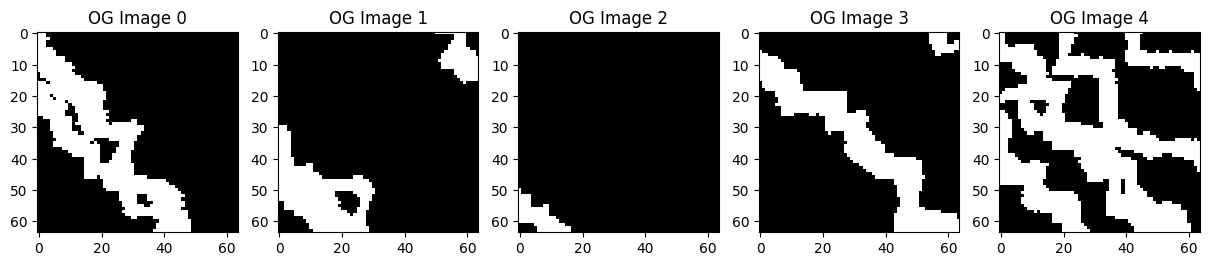

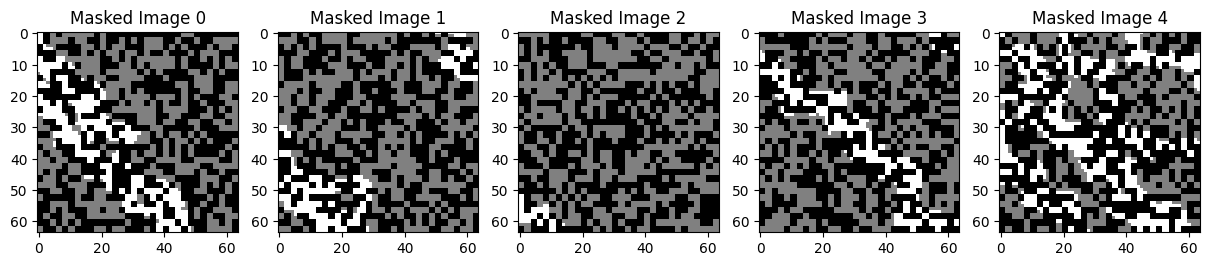

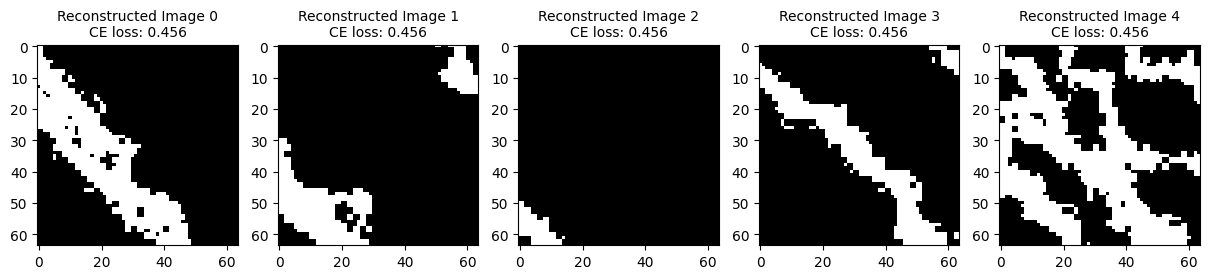

<ipython-input-20-c5cf3d1be29a>:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PointSSIM_scores = PointSSIM_loss(torch.tensor(batch_test,dtype=torch.float),torch.tensor(np.array(reconstructed_images),dtype=torch.float))
/content/GeoDecepticon/PointSSIM_Loss.py:155: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  features1 = torch.tensor(features1, dtype=img_batch1.dtype, device=img_batch1.device)


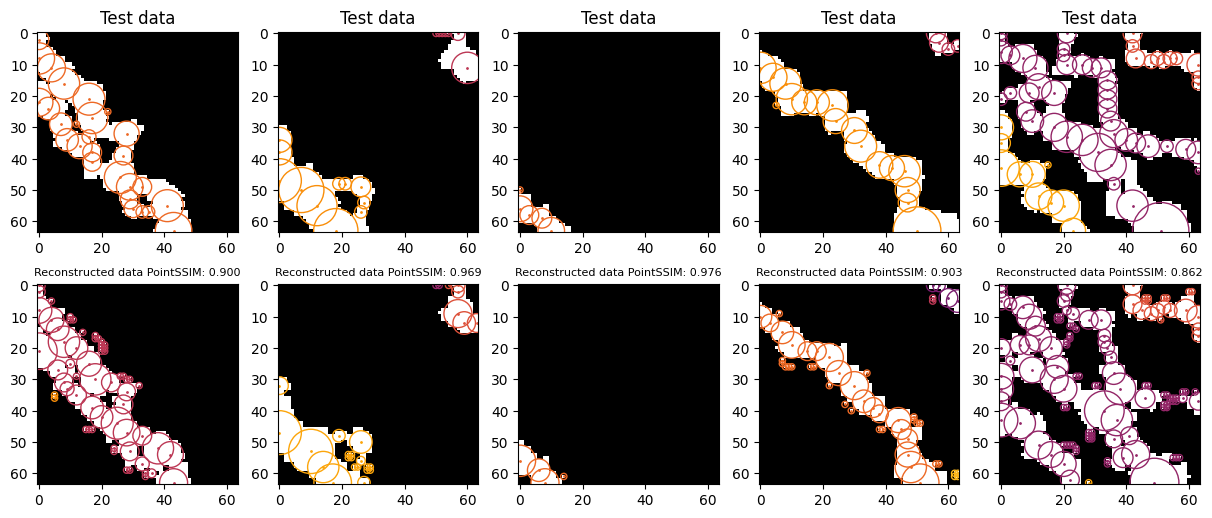

In [20]:
PointSSIM_loss = PointSSIMLoss()
CE_loss = nn.CrossEntropyLoss()
# Load the latest epoch of the vision transformer
checkpoint_path = "vision_transformer_sample.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
# Take a test image and mask randomly 50% of cells
batch_test = test_images[:5]
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
  ax[i].imshow(batch_test[i],cmap="gray")
  ax[i].set_title("OG Image " + str(i))
plt.show()

batch_test = test_images[:5]
# Preprocess images
patch_indices = torch.stack([preprocess_image(img) for img in batch_test]).long() #(btach_size,max_patches)
masked_patches = patch_indices.clone() #(btach_size,max_patches)

current_num_mask = 512
batch_size = 5
# Generate random indices for masking
random_indices = torch.rand(batch_size, max_patches).argsort(dim=1)[:, :current_num_mask]
# Create the mask tensor
mask = torch.zeros((batch_size, max_patches), dtype=torch.bool)
mask.scatter_(1, random_indices, True)

#Mask
masked_patches[mask] = num_tokens - 1  # Replace masked patches with the mask token

# Prepare masked image for visualization
visualized_masked_patches = masked_patches.cpu().clone()
visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
masked_images = []
for i in range(batch_size):
  masked_images.append(reconstruct_image_from_patches(visualized_masked_patches[i]))

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
  ax[i].imshow(masked_images[i],cmap="gray")
  ax[i].set_title("Masked Image " + str(i))
plt.show()

# Initialize predicted_indices with original patch indices
predicted_indices = patch_indices.cpu().clone()

# Forward pass
logits = model(masked_patches.to(device)) # (batch_size,max_patches,num_tokens - 1)
# Isolate the masked patches
# Get the indices of True values
indices = mask.nonzero(as_tuple=True)  # Returns indices where mask is True
# Extract logits at masked positions while maintaining row-wise structure
masked_logits = logits[indices[0], indices[1]]  # Extracts all True-index logits
masked_logits = masked_logits.view(batch_size, current_num_mask, -1)  # (batch_size, current_num_mask, num_tokens-1)
masked_patch_indices = patch_indices[indices[0], indices[1]]  # Extracts all True-index patch indices
masked_patch_indices = masked_patch_indices.view(batch_size, current_num_mask) #(batch_size, current_num_mask)

#Compute logits
loss = CE_loss(masked_logits.view(-1, num_tokens-1).to(device), masked_patch_indices.view(-1).to(device))

# Predict only the masked indices
masked_predictions = torch.argmax(masked_logits, dim=-1).cpu()  # Shape: [batch_size, current_num_mask]
reconstructed_images = []
for i in range(batch_size):
  predicted_indices[i][mask[i]] = masked_predictions[i]
  reconstructed_images.append(reconstruct_image_from_patches(predicted_indices[i]))

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
  ax[i].imshow(reconstructed_images[i],cmap="gray")
  ax[i].set_title(f"Reconstructed Image {i}\nCE loss: {loss.item():.3f}", fontsize=10)
plt.show()

# Now we do PointSSIM on both OG and Reconstructed images
anchors_test = []
anchors_reconstructed = []
for i in range(batch_size):
  anchors_test.append(PointSSIM_loss.custom_anchors(batch_test[i],batch_test[i].shape[0],True))
  anchors_reconstructed.append(PointSSIM_loss.custom_anchors(reconstructed_images[i],reconstructed_images[i].shape[0],True))

PointSSIM_scores = PointSSIM_loss(torch.tensor(batch_test,dtype=torch.float),torch.tensor(np.array(reconstructed_images),dtype=torch.float))

import seaborn as sns
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    nr_anchor_points_test = np.sum(anchors_test[i][0])
    nr_anchor_points_reconstructed = np.sum(anchors_reconstructed[i][0])
    ax[0,i].imshow(batch_test[i], cmap='gray')
    ax[0,i].set_title('Test data')
    ax[1,i].imshow(reconstructed_images[i], cmap='gray')
    ax[1,i].set_title(f'Reconstructed data PointSSIM: {PointSSIM_scores[i]:.3f}', fontsize=8)
    colors = sns.color_palette('inferno', int(np.max(anchors_test[i][2])) + 1)
    for k in range(int(nr_anchor_points_test)):
        x, y = np.where(anchors_test[i][0])[0][k], np.where(anchors_test[i][0])[1][k]
        r = anchors_test[i][1][x, y]
        ax[0,i].plot(y, x, 'o', markersize=1, color=colors[int(anchors_test[i][2][x, y])])
        circle = plt.Circle((y, x), r, color=colors[int(anchors_test[i][2][x, y])], fill=False)
        ax[0,i].add_artist(circle)
    colors = sns.color_palette('inferno', int(np.max(anchors_reconstructed[i][2])) + 1)
    for k in range(int(nr_anchor_points_reconstructed)):
        x, y = np.where(anchors_reconstructed[i][0])[0][k], np.where(anchors_reconstructed[i][0])[1][k]
        r = anchors_reconstructed[i][1][x, y]
        ax[1,i].plot(y, x, 'o', markersize=1, color=colors[int(anchors_reconstructed[i][2][x, y])])
        circle = plt.Circle((y, x), r, color=colors[int(anchors_reconstructed[i][2][x, y])], fill=False)
        ax[1,i].add_artist(circle)
plt.show()

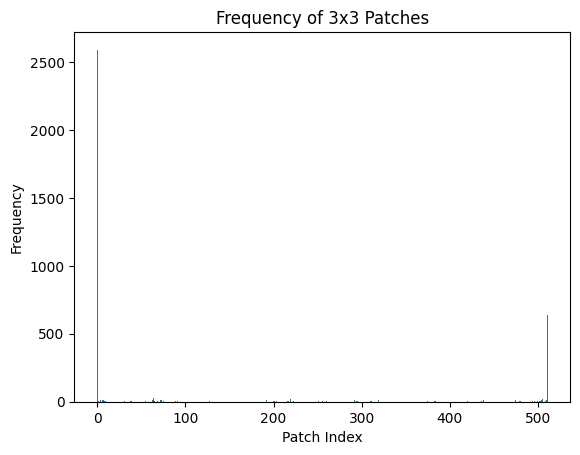

In [24]:
import numpy as np
from scipy.signal import convolve2d

def count_3x3_patches(binary_image):
    # Ensure binary_image is a NumPy array
    binary_image = np.array(binary_image, dtype=np.uint8)

    # Define convolutional kernel to extract 3x3 patches
    kernel = np.array([[256, 128, 64],  # Top row (highest bits)
                       [32, 16, 8],     # Middle row
                       [4, 2, 1]])      # Bottom row (lowest bits)

    # Apply convolution to compute unique index for each 3x3 patch
    patch_indices = convolve2d(binary_image, kernel, mode='valid')

    # Count occurrences of each patch
    patch_counts = np.bincount(patch_indices.ravel(), minlength=512)

    return patch_counts

# Example: Generate a random 64x64 binary image
binary_image = batch_test[0]

# Get patch frequencies
patch_frequencies = count_3x3_patches(binary_image)

# Display patch frequencies
plt.bar(range(512), patch_frequencies)
plt.xlabel('Patch Index')
plt.ylabel('Frequency')
plt.title('Frequency of 3x3 Patches')
plt.show()

In [34]:
# Validation part
def validate(model,epoch,num_masked,marginal_priors):
  PointSSIM_loss = PointSSIMLoss()
  #checkpoint_path = f"checkpoints/vision_transformer_epoch_{epoch+1}.pth"
  checkpoint_path = "vision_transformer_sample.pth"
  checkpoint = torch.load(checkpoint_path)
  model.load_state_dict(checkpoint["model_state_dict"])
  model.eval()
  batch_test_idx = np.random.choice(np.arange(test_data.shape[0]), 60)
  batch_test = torch.tensor(test_data[batch_test_idx],dtype=torch.long)

  # Preprocess images
  patch_indices = torch.stack([preprocess_image(img) for img in batch_test]).long() #(btach_size,max_patches)
  masked_patches = patch_indices.clone() #(btach_size,max_patches)

  current_num_mask = num_masked
  batch_size = 60
  # Generate random indices for masking
  random_indices = torch.rand(batch_size, max_patches).argsort(dim=1)[:, :current_num_mask]
  # Create the mask tensor
  mask = torch.zeros((batch_size, max_patches), dtype=torch.bool)
  mask.scatter_(1, random_indices, True)

  #Mask
  masked_patches[mask] = num_tokens - 1  # Replace masked patches with the mask token

  # Prepare masked image for visualization
  visualized_masked_patches = masked_patches.cpu().clone()
  visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
  masked_images = []
  for i in range(batch_size):
    masked_images.append(reconstruct_image_from_patches(visualized_masked_patches[i]))


  # Initialize predicted_indices with original patch indices
  predicted_indices = patch_indices.cpu().clone()

  # Forward pass
  logits = model(masked_patches.to(device)) # (batch_size,max_patches,num_tokens - 1)
  # Isolate the masked patches
  # Get the indices of True values
  indices = mask.nonzero(as_tuple=True)  # Returns indices where mask is True
  # Extract logits at masked positions while maintaining row-wise structure
  masked_logits = logits[indices[0], indices[1]]  # Extracts all True-index logits
  masked_logits = masked_logits.view(batch_size, current_num_mask, -1)  # (batch_size, current_num_mask, num_tokens-1)
  masked_patch_indices = patch_indices[indices[0], indices[1]]  # Extracts all True-index patch indices
  masked_patch_indices = masked_patch_indices.view(batch_size, current_num_mask) #(batch_size, current_num_mask)

  #Compute logits
  loss = CE_loss(masked_logits.view(-1, num_tokens-1).to(device), masked_patch_indices.view(-1).to(device))

  # Predict only the masked indices
  masked_predictions = torch.argmax(masked_logits, dim=-1).cpu()  # Shape: [batch_size, current_num_mask]
  reconstructed_images = []
  for i in range(batch_size):
    predicted_indices[i][mask[i]] = masked_predictions[i]
    reconstructed_images.append(reconstruct_image_from_patches(predicted_indices[i]))

  #Compute the PointSSIM scores
  PointSSIM_scores = PointSSIM_loss(torch.tensor(batch_test,dtype=torch.float),torch.tensor(np.array(reconstructed_images),dtype=torch.float))

  # Compute the 3x3-patches
  three_patches_test = np.mean(np.array([count_3x3_patches(img) for img in batch_test]),axis=0) #(512)
  three_patches_reconstructed = np.mean(np.array([count_3x3_patches(img) for img in reconstructed_images]),axis=0) #(512)
  three_patch_prob_test = three_patches_test/np.sum(three_patches_test)
  three_patch_prob_reconstructed = three_patches_reconstructed/np.sum(three_patches_reconstructed)

  return loss.item(),PointSSIM_scores,three_patch_prob_test,three_patch_prob_reconstructed,marginal_priors




In [46]:
print(torch.mean(torch.softmax(logits,dim=-1),dim=0).shape)
print(validate_metrics[4].shape)

torch.Size([1024, 16])
torch.Size([1024, 16])


In [49]:
import wandb
wandb.login()

# Initialize wandb project
wandb.init(
    project="vision-transformer",
    config={
        "batch_size": batch_size,
        "embed_dim": embed_dim,
        "num_heads": num_heads,
        "feedforward_dim": feedforward_dim,
        "num_layers": num_layers,
        "num_tokens": num_tokens,
        "max_patches": max_patches,
        "dropout": dropout,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "hidden_dim": hidden_dim,
    },
)

reconstructed_images = []
original_images = []
prev_loss = []
# Directory to save checkpoints
os.makedirs("checkpoints", exist_ok=True)
maskings = y

# Set num mask
current_num_mask = 1
eps = 0.005
curr_loss = 1000
# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    current_num_mask = convergence_scheduler(current_num_mask,prev_loss,curr_loss,eps)
    prev_loss.append(curr_loss)
    for batch_idx, images in enumerate(dataloader):
        # Preprocess images
        patch_indices = torch.stack([preprocess_image(img) for img in images]).long() #(btach_size,max_patches)
        masked_patches = patch_indices.clone() #(btach_size,max_patches)

        # Generate random indices for masking
        random_indices = torch.rand(batch_size, max_patches).argsort(dim=1)[:, :current_num_mask]
        # Create the mask tensor
        mask = torch.zeros((batch_size, max_patches), dtype=torch.bool)
        mask.scatter_(1, random_indices, True)

        #Mask
        masked_patches[mask] = num_tokens - 1  # Replace masked patches with the mask token

        # Define weighted CrossEntropyLoss
        criterion = nn.CrossEntropyLoss()
        # Define PointSSIM loss

        # Move to device
        masked_patches, patch_indices, mask = (
            masked_patches.to(device),
            patch_indices.to(device),
            mask.to(device),
        )

        # Forward pass
        logits = model(masked_patches) # (batch_size,max_patches,num_tokens - 1)
        # Isolate the masked patches
        # Get the indices of True values
        indices = mask.nonzero(as_tuple=True)  # Returns indices where mask is True
        # Extract logits at masked positions while maintaining row-wise structure
        masked_logits = logits[indices[0], indices[1]]  # Extracts all True-index logits
        masked_patch_indices = patch_indices[indices[0], indices[1]]  # Extracts all True-index patch indices
        # Reshape to [batch_size, num_masked_patches, num_classes]
        masked_logits = masked_logits.view(batch_size, current_num_mask, -1)  # (batch_size, current_num_mask, num_tokens-1)
        masked_patch_indices = masked_patch_indices.view(batch_size, current_num_mask) #(batch_size, current_num_mask)


        #Compute logits
        loss = criterion(masked_logits.view(-1, num_tokens-1), masked_patch_indices.view(-1))
        total_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Log batch metrics
        wandb.log({"batch loss": loss.item()})

        # Visualization for the first batch in the epoch
        if batch_idx == 0:
          with torch.no_grad():
              # Initialize predicted_indices with original patch indices
              predicted_indices = patch_indices.cpu()[0].clone()

              # Predict only the masked indices
              masked_predictions = torch.argmax(masked_logits, dim=-1).cpu()  # Shape: [batch_size, current_num_mask]
              predicted_indices[mask[0]] = masked_predictions[0]  # Update only masked indices

              # Reconstruct images
              reconstructed_image = reconstruct_image_from_patches(predicted_indices)
              reconstructed_images.append(reconstructed_image)
              original_images.append(reconstruct_image_from_patches(patch_indices.cpu()[0]))


              # Prepare masked image for visualization
              visualized_masked_patches = masked_patches.cpu()[0].clone()
              visualized_masked_patches[visualized_masked_patches == num_tokens - 1] = -1
              masked_image = reconstruct_image_from_patches(visualized_masked_patches)

              # Log visualizations to wandb
              wandb.log({
                  "Original Image": wandb.Image(
                      reconstruct_image_from_patches(patch_indices.cpu()[0])
                  ),
                  "Masked Image": wandb.Image(masked_image, caption="Masked Image"),
                  "Reconstructed Image": wandb.Image(
                      reconstructed_image, caption="Reconstructed Image"
                  ),
              })

    avg_loss = total_loss / len(dataloader)
    curr_loss = avg_loss
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}")

    # Log epoch metrics
    wandb.log({"epoch_loss": avg_loss, "masked_patches": current_num_mask})

    # Save checkpoint periodically
    if (epoch + 1) % 100 == 0:
        validation_metrics = validate(model,epoch,current_num_mask,marginal_priors)
        # Create a table to store data
        table = wandb.Table(columns=["Patch ID", "3x3_freq_test_images", "3x3_freq_reconstructed_images"])

        # Populate the table
        for i in range(512):
            table.add_data(i, validation_metrics[2][i], validation_metrics[3][i])

        # Create a side-by-side bar plot
        bar_plot = wandb.plot.bar(table, "Patch ID", ["3x3_freq_test_images", "3x3_freq_reconstructed_images"],
                                  title="3x3 Patch Frequency Comparison")

        wandb.log({
            "validation_loss": validation_metrics[0],
            "PointSSIM_loss": 1-torch.mean(validation_metrics[1]),
            "Patch Frequency Bar Plot": bar_plot
        })
        checkpoint_path = f"checkpoints/vision_transformer_epoch_{epoch+1}.pth"
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            checkpoint_path,
        )
        print(f"Checkpoint saved for epoch {epoch+1}")
        wandb.save(checkpoint_path)

        #Do validation
        model.eval()


# Save the final model
torch.save(model.state_dict(), "vision_transformer_final_balanced.pth")
wandb.save("vision_transformer_final_balanced.pth")
print("Final model saved as 'vision_transformer_final_balanced.pth'.")
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch [1/3000] completed. Average Loss: 1.3797
Epoch [2/3000] completed. Average Loss: 1.0519
Epoch [3/3000] completed. Average Loss: 1.0067
Epoch [4/3000] completed. Average Loss: 1.0108
Epoch [5/3000] completed. Average Loss: 0.9935
Epoch [6/3000] completed. Average Loss: 1.0415
Epoch [7/3000] completed. Average Loss: 0.9778
Epoch [8/3000] completed. Average Loss: 0.9745
Epoch [9/3000] completed. Average Loss: 0.9366
Epoch [10/3000] completed. Average Loss: 0.9679
Epoch [11/3000] completed. Average Loss: 0.9795
Epoch [12/3000] completed. Average Loss: 0.9569
Epoch [13/3000] completed. Average Loss: 0.9745
Epoch [14/3000] completed. Average Loss: 0.9676
Epoch [15/3000] completed. Average Loss: 0.9669
Epoch [16/3000] completed. Average Loss: 0.9844
Epoch [17/3000] completed. Average Loss: 0.9507
Epoch [18/3000] completed. Average Loss: 0.9558
Epoch [19/3000] completed. Average Loss: 0.9758
Epoch [20/3000] completed. Average Loss: 0.9520
Epoch [21/3000] completed. Average Loss: 0.9575
E

<ipython-input-34-3034ee500c0c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
<ipython-input-34-3034ee500c0c>:60: UserWarning: To

Checkpoint saved for epoch 100
Epoch [101/3000] completed. Average Loss: 0.4332
Epoch [102/3000] completed. Average Loss: 0.4116
Epoch [103/3000] completed. Average Loss: 0.3976
Epoch [104/3000] completed. Average Loss: 0.3863
Epoch [105/3000] completed. Average Loss: 0.3869
Epoch [106/3000] completed. Average Loss: 0.3889
Epoch [107/3000] completed. Average Loss: 0.3755
Epoch [108/3000] completed. Average Loss: 0.3780
Epoch [109/3000] completed. Average Loss: 0.3676
Epoch [110/3000] completed. Average Loss: 0.3774
Epoch [111/3000] completed. Average Loss: 0.3726
Epoch [112/3000] completed. Average Loss: 0.3723
Epoch [113/3000] completed. Average Loss: 0.3549
Epoch [114/3000] completed. Average Loss: 0.3655
Epoch [115/3000] completed. Average Loss: 0.3639
Epoch [116/3000] completed. Average Loss: 0.3621
Epoch [117/3000] completed. Average Loss: 0.3587
Epoch [118/3000] completed. Average Loss: 0.3606
Epoch [119/3000] completed. Average Loss: 0.3622
Epoch [120/3000] completed. Average Lo

KeyboardInterrupt: 